<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/time-series/TIme_Series_Forcecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os, sys;
import glob 
import gc
gc.enable()
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,6),'axes.grid':False})
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

TensorFlow 2.x selected.


In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

13574144/13568290 [==============================] - 1s 0us/step


In [0]:
csv_path, _ = os.path.splitext(zip_path)

In [0]:
df = pd.read_csv(csv_path, low_memory=False)

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 300000

In [0]:
tf.random.set_seed(2020)

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb199e53278>],
      dtype=object)

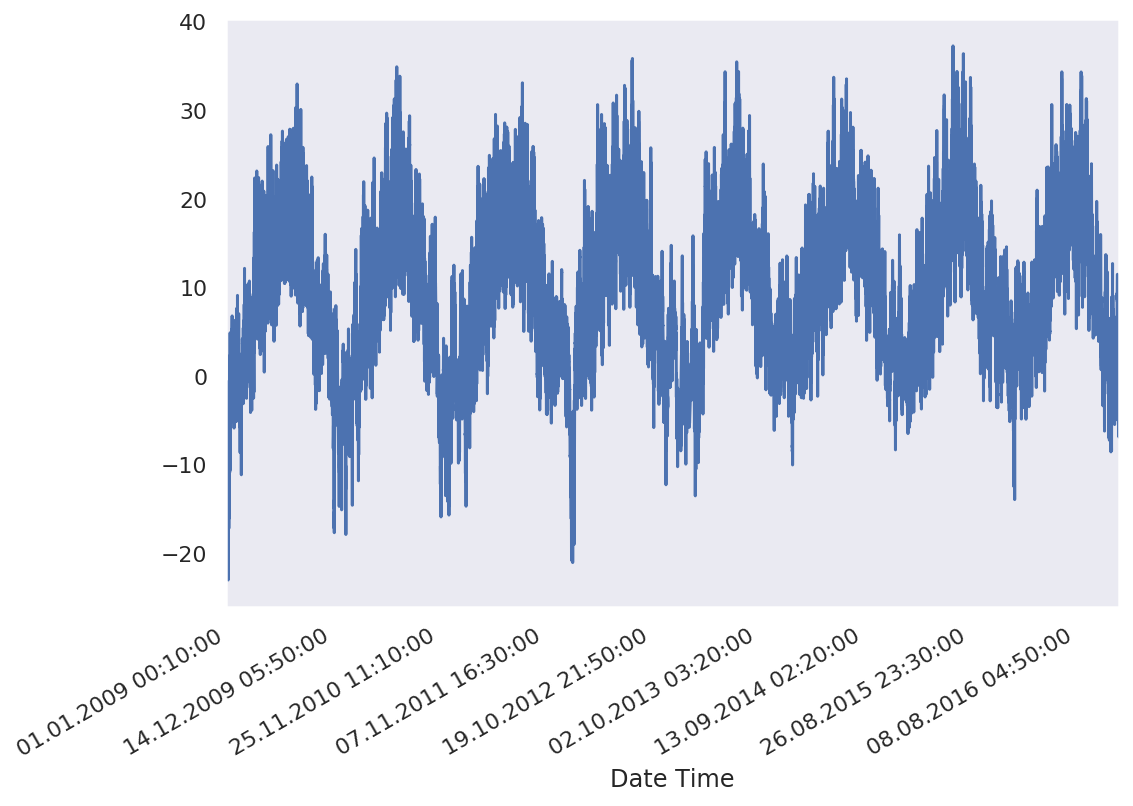

In [10]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data - uni_train_mean) / uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,univariate_past_history,univariate_future_target)

In [15]:
print('Single window of past history')
print(x_train_uni[0])
print('Target temperature predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
Target temperature predict
-2.1041848598100876


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-','rx','go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

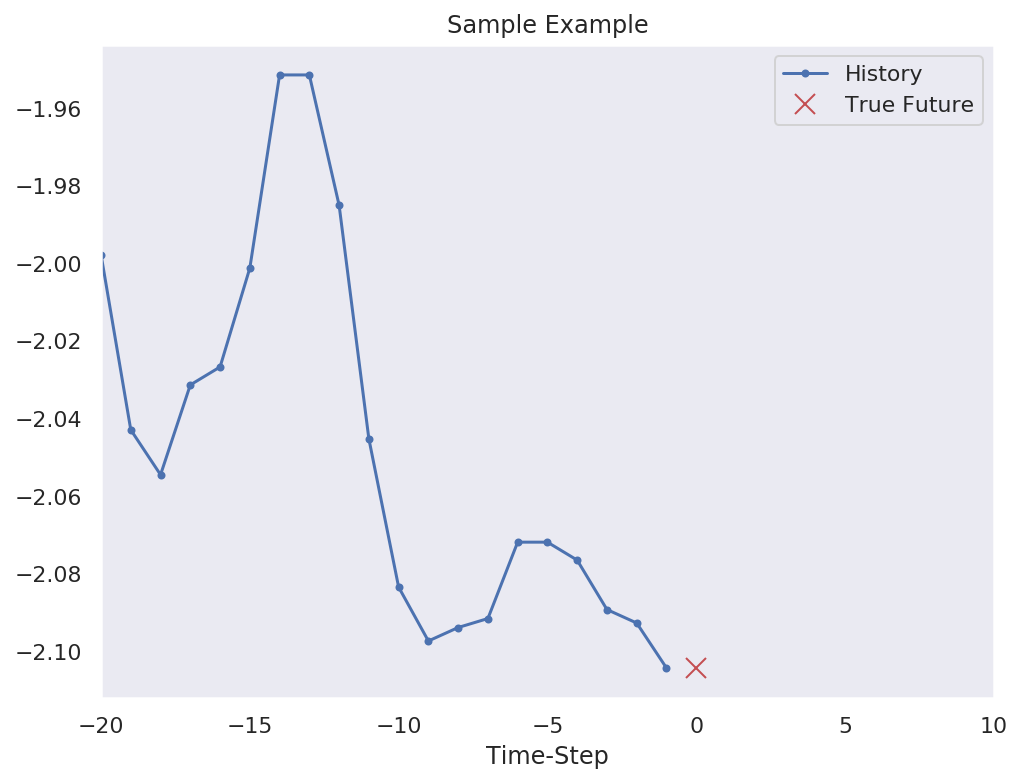

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

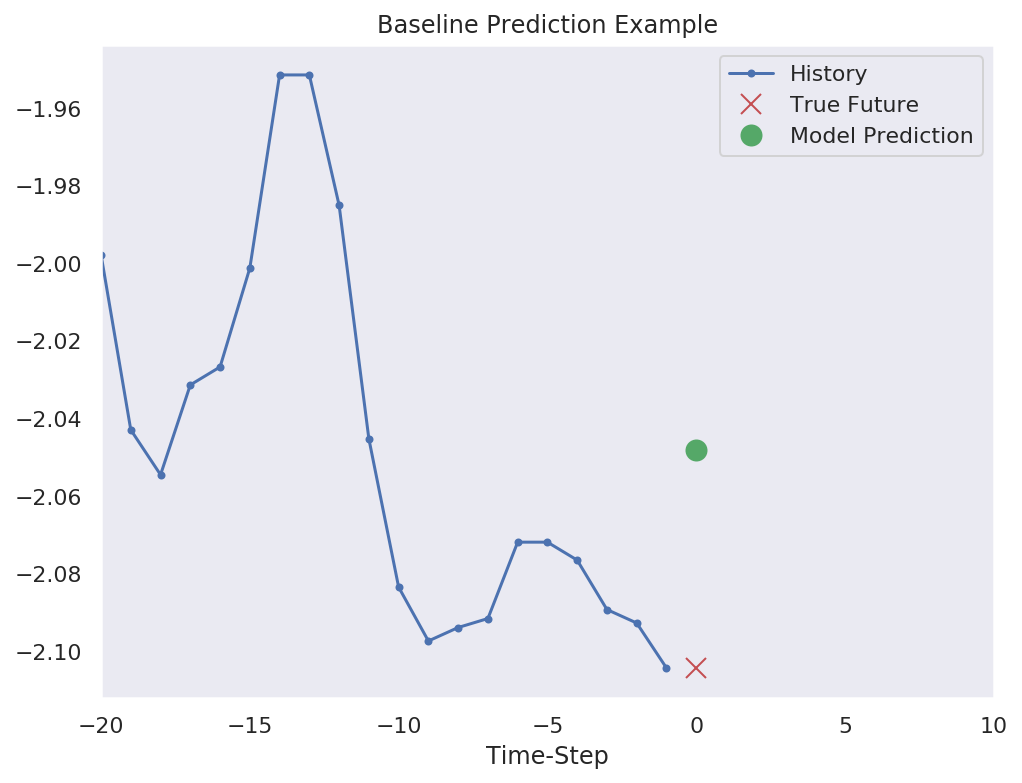

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
single_lstm_model = tf.keras.models.Sequential([
                                                tf.keras.layers.LSTM(512, input_shape=x_train_uni.shape[-2:]),
                                                tf.keras.layers.Dense(1)
])

single_lstm_model.compile(optimizer='adam', loss='mae')

In [23]:
single_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [24]:
for x, y in val_univariate.take(1):
  print(single_lstm_model.predict(x).shape)

(256, 1)


In [25]:
EVALUATION_INTERVAL = 200
EPOCHS = 20

single_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0589 - val_loss: 0.0280
Epoch 2/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0329 - val_loss: 0.0229
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0286 - val_loss: 0.0196
Epoch 4/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0248 - val_loss: 0.0185
Epoch 5/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0209 - val_loss: 0.0162
Epoch 6/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0209 - val_loss: 0.0149
Epoch 7/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0187 - val_loss: 0.0184
Epoch 8/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0186 - val_loss: 0.0128
Epoch 9/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0165 - val_loss: 0.0125
Epoch 10/20
200/200 [===========================

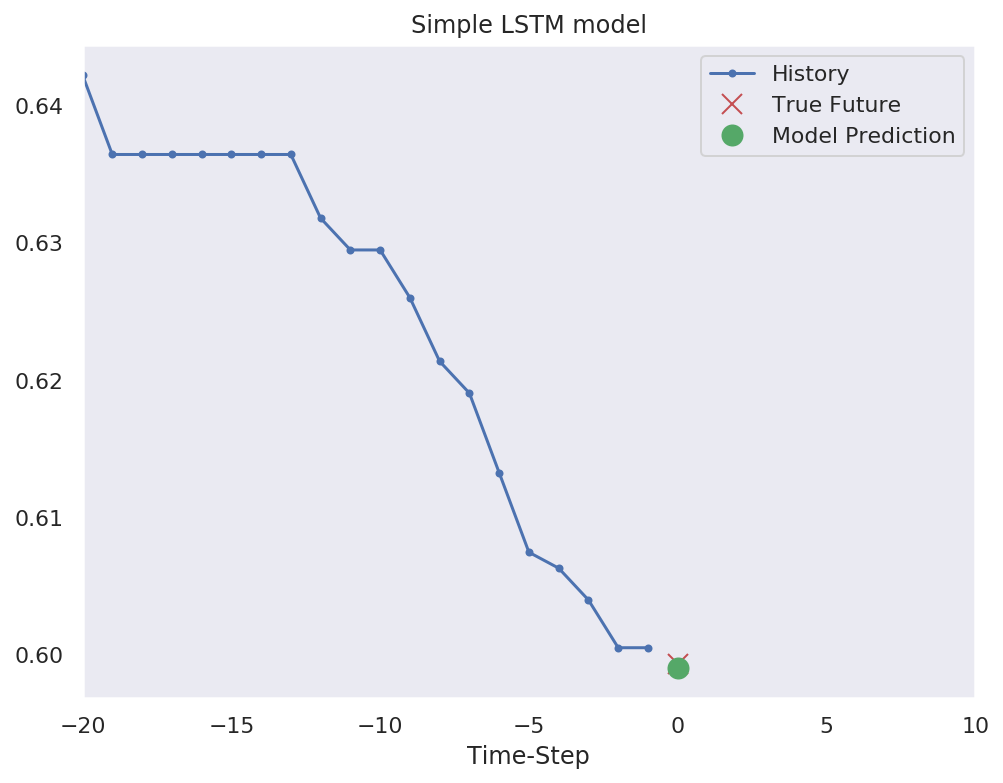

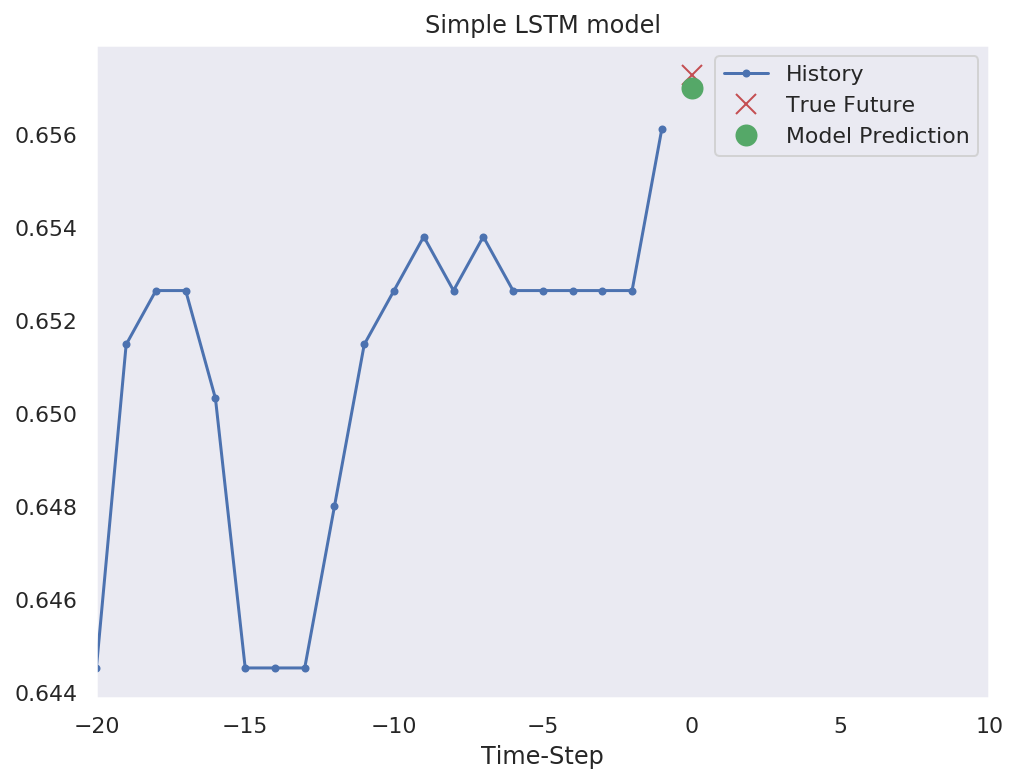

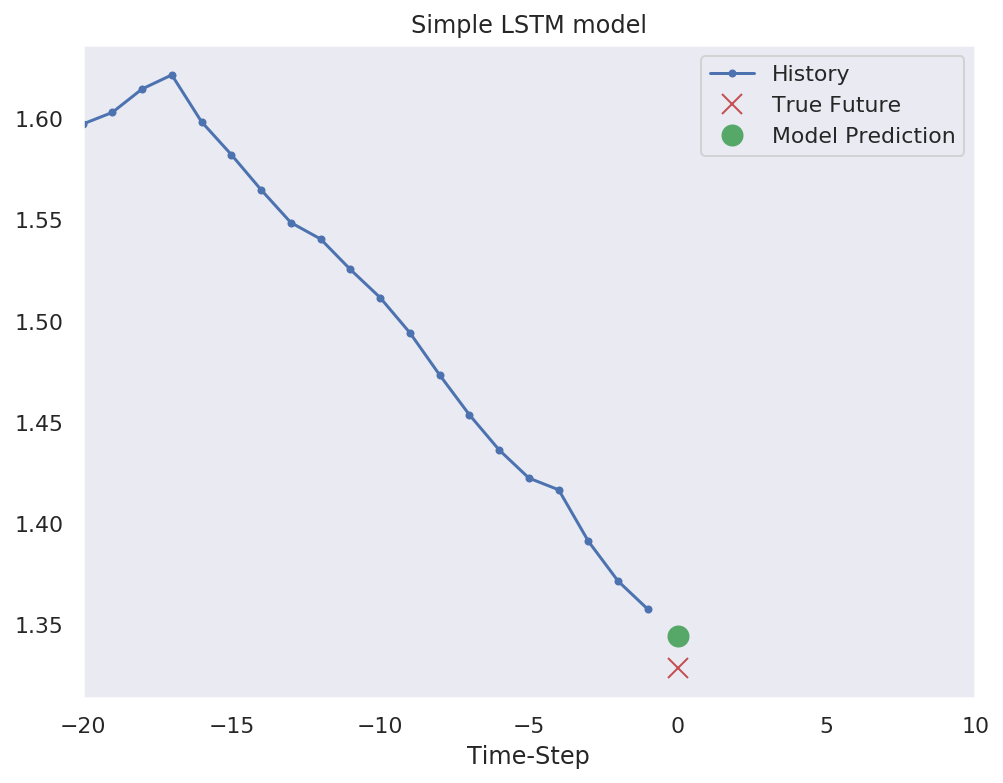

In [26]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    single_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [27]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1803b64a8>,
      dtype=object)

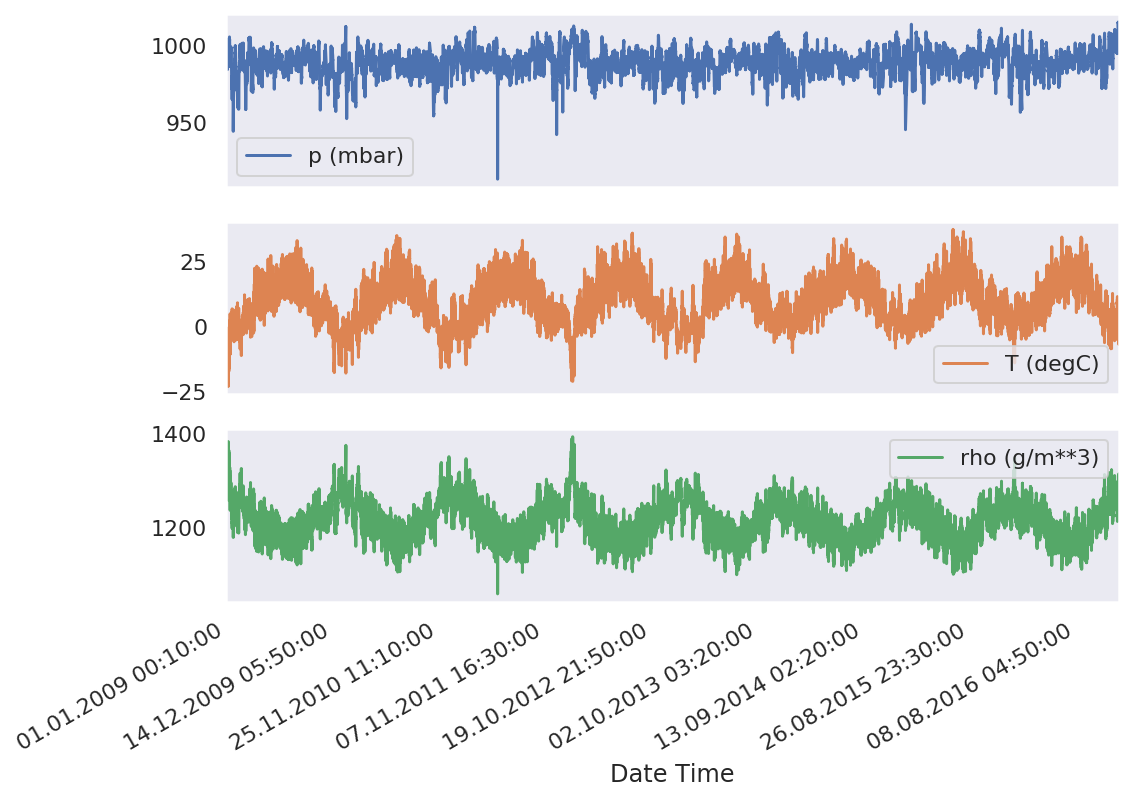

In [28]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  return np.array(data), np.array(labels)

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,1], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,1], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [33]:
print('Single window of past history: {}'.format(x_train_single[0].shape))

Single window of past history: (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single)).batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(512, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mae')

In [36]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=20, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_single,validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 14s 68ms/step - loss: 0.3268 - val_loss: 0.3382
Epoch 2/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2745 - val_loss: 0.2370
Epoch 3/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2696 - val_loss: 0.2509
Epoch 4/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2589 - val_loss: 0.2316
Epoch 5/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2217 - val_loss: 0.2350
Epoch 6/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2300 - val_loss: 0.2788
Epoch 7/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2280 - val_loss: 0.2788
Epoch 8/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2245 - val_loss: 0.2891
Epoch 9/20
200/200 [==============================] - 11s 57ms/step - loss: 0.2141 - val_loss: 0.2605
Epoch 10/20
200/200 [==================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

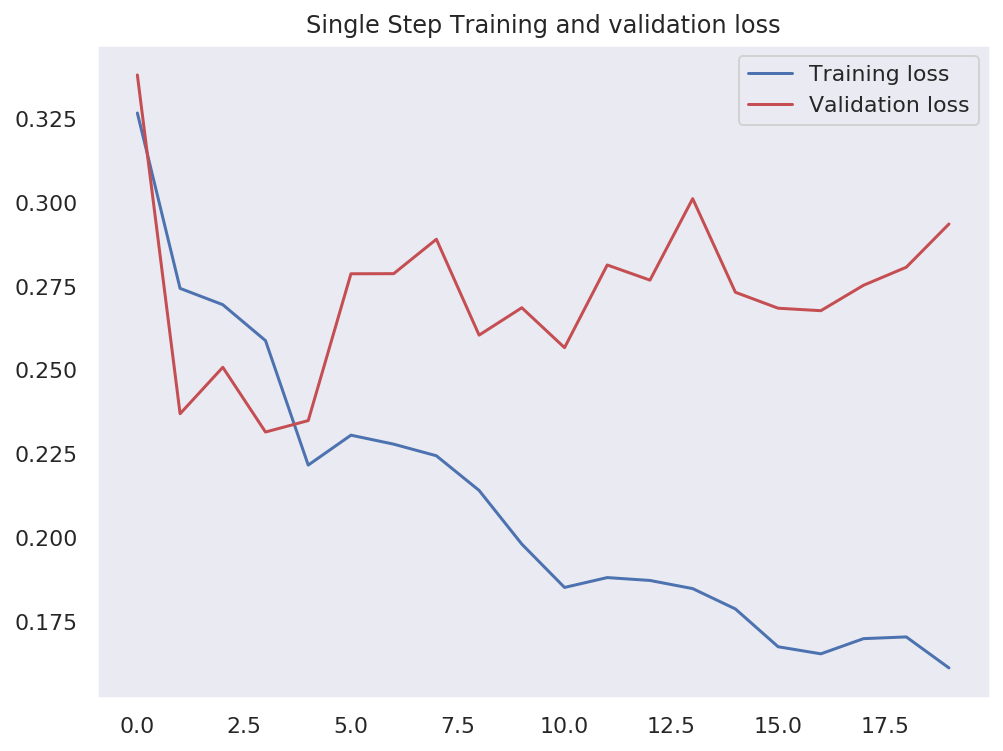

In [39]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

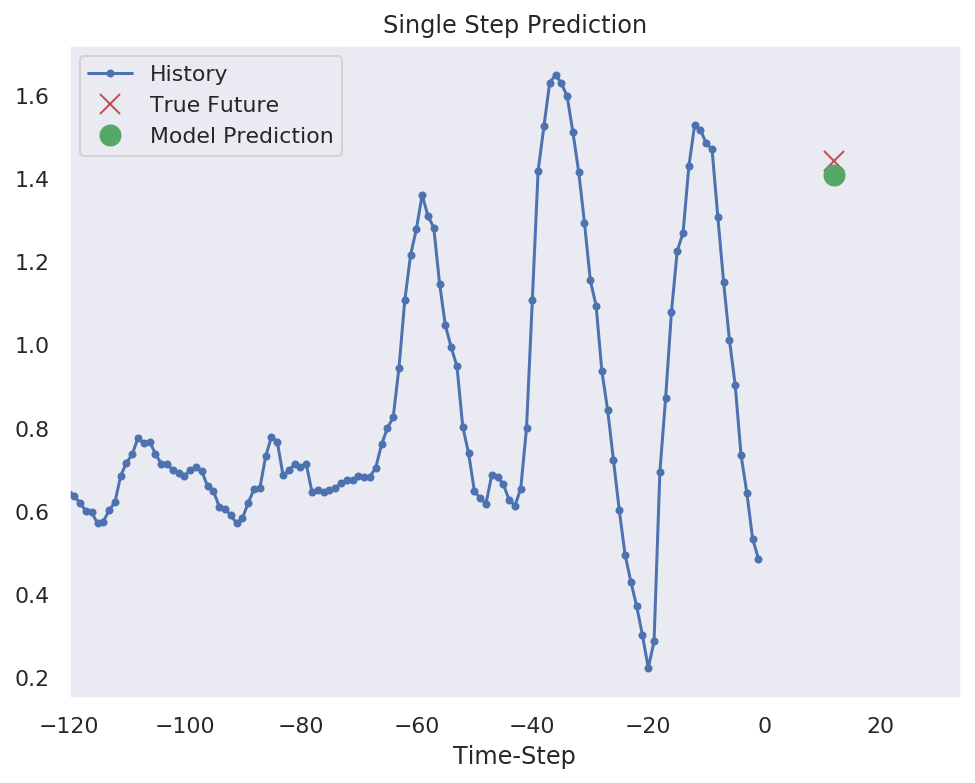

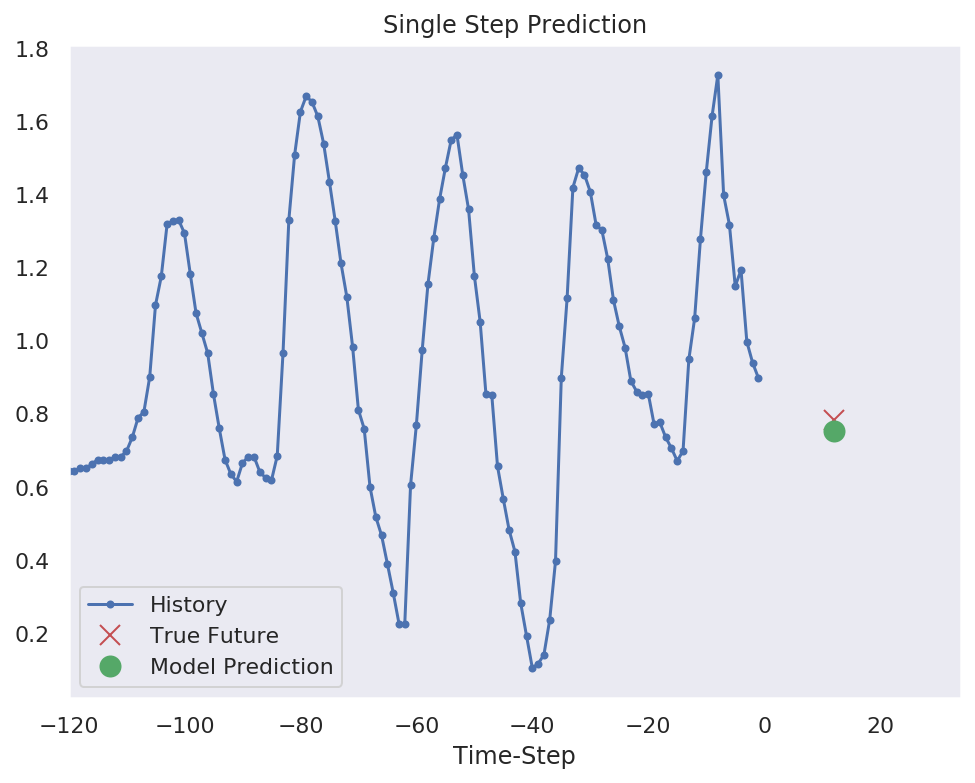

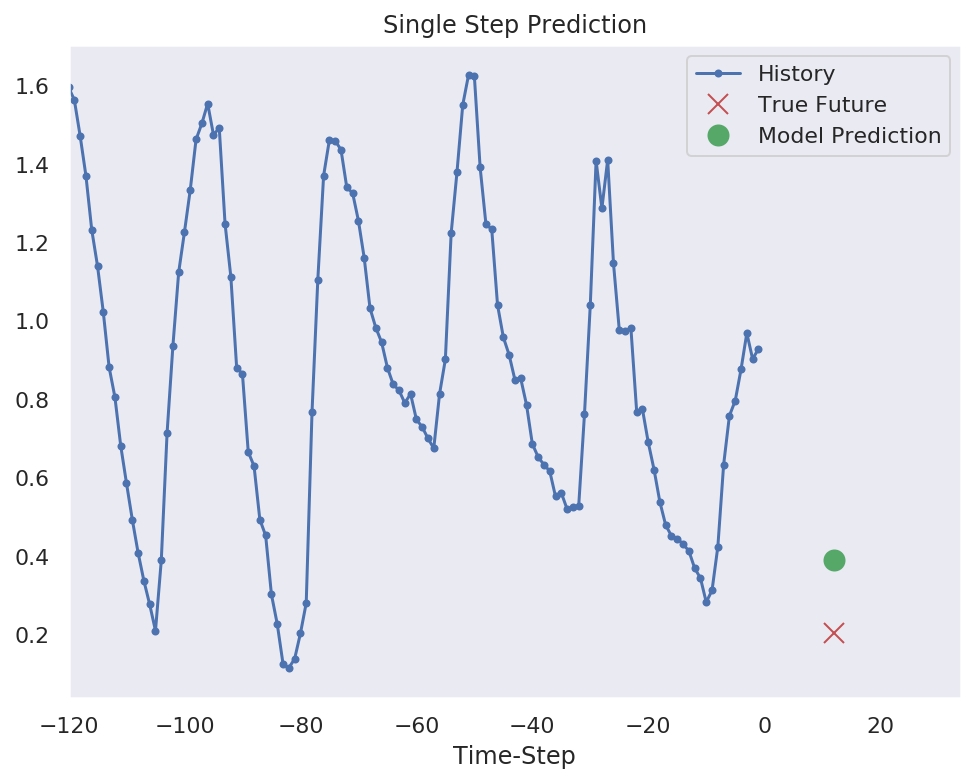

In [40]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,1],0,TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,1],TRAIN_SPLIT, None, past_history, future_target, STEP)

In [42]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

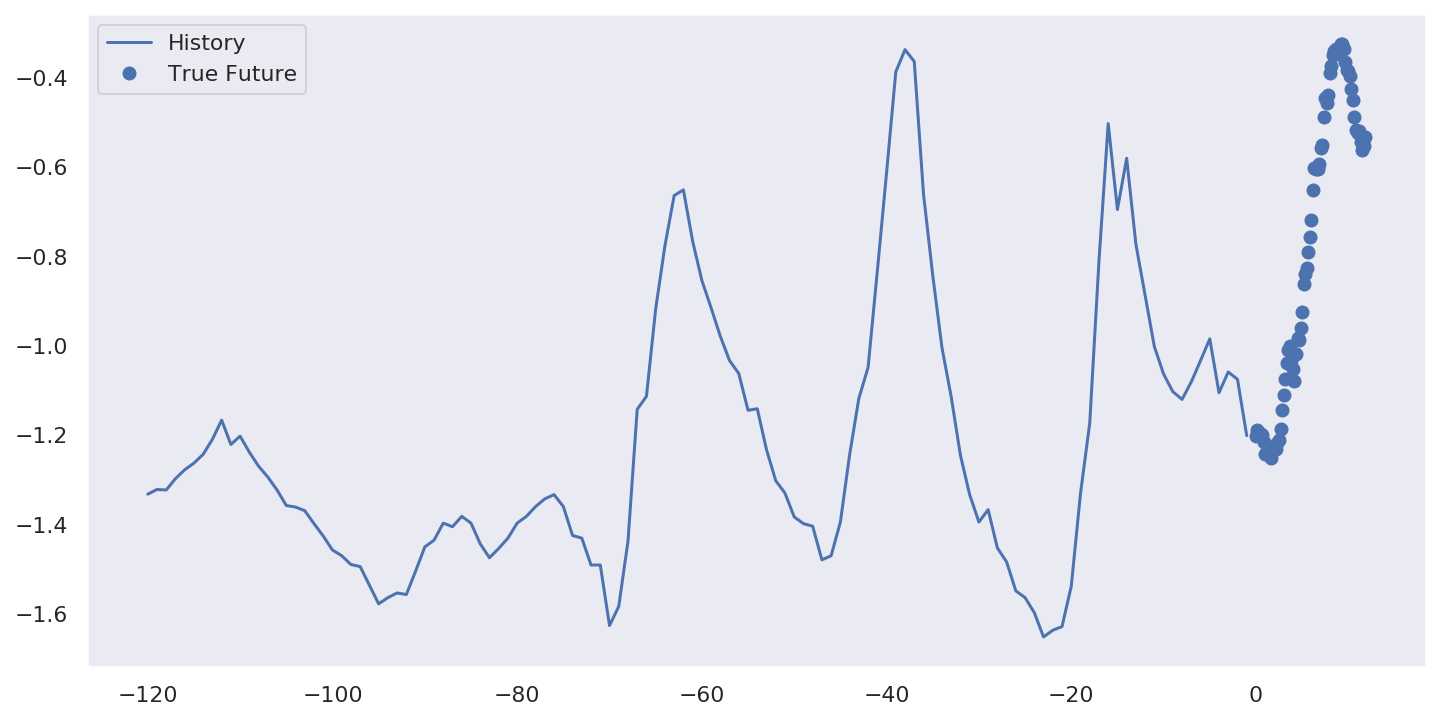

In [54]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [59]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [60]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 32s 161ms/step - loss: 0.6687 - val_loss: 0.3689
Epoch 2/20
200/200 [==============================] - 28s 142ms/step - loss: 21.9132 - val_loss: 0.2960
Epoch 3/20
200/200 [==============================] - 28s 140ms/step - loss: 0.3897 - val_loss: 0.2908
Epoch 4/20
200/200 [==============================] - 28s 141ms/step - loss: 33.4880 - val_loss: 0.5716
Epoch 5/20
200/200 [==============================] - 28s 141ms/step - loss: 0.4892 - val_loss: 0.2941
Epoch 6/20
200/200 [==============================] - 28s 141ms/step - loss: 0.3410 - val_loss: 0.2761
Epoch 7/20
200/200 [==============================] - 28s 142ms/step - loss: 40.6864 - val_loss: 0.2655
Epoch 8/20
200/200 [==============================] - 28s 141ms/step - loss: 0.3067 - val_loss: 0.2445
Epoch 9/20
200/200 [==============================] - 28s 142ms/step - loss: 0.2419 - val_loss: 0.2156
Epoch 10/20
200/200 [======

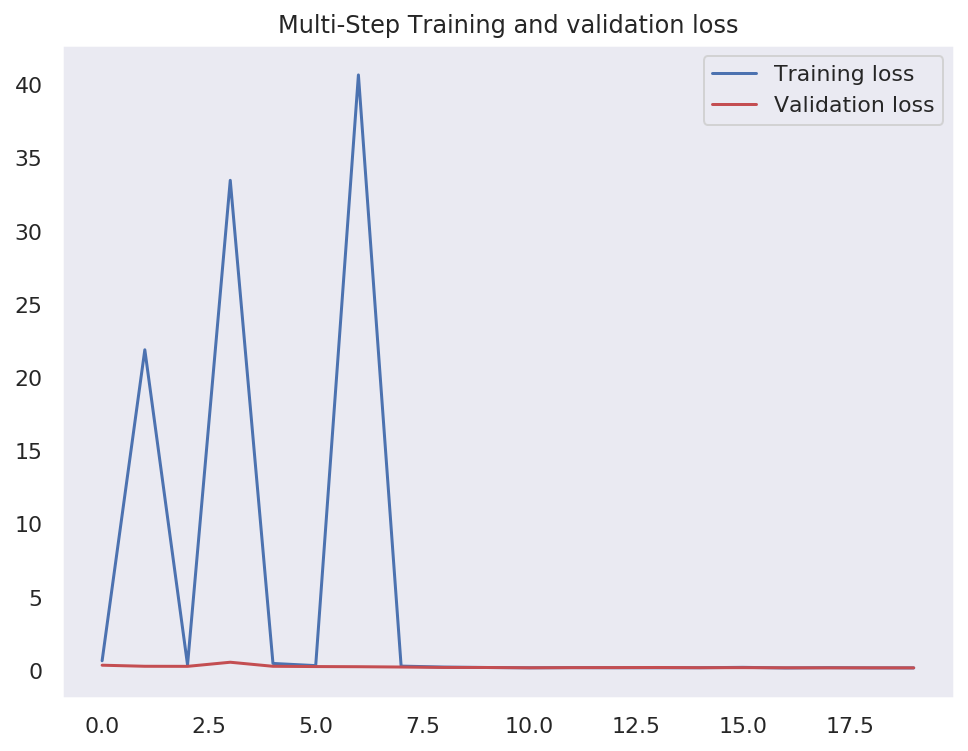

In [61]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

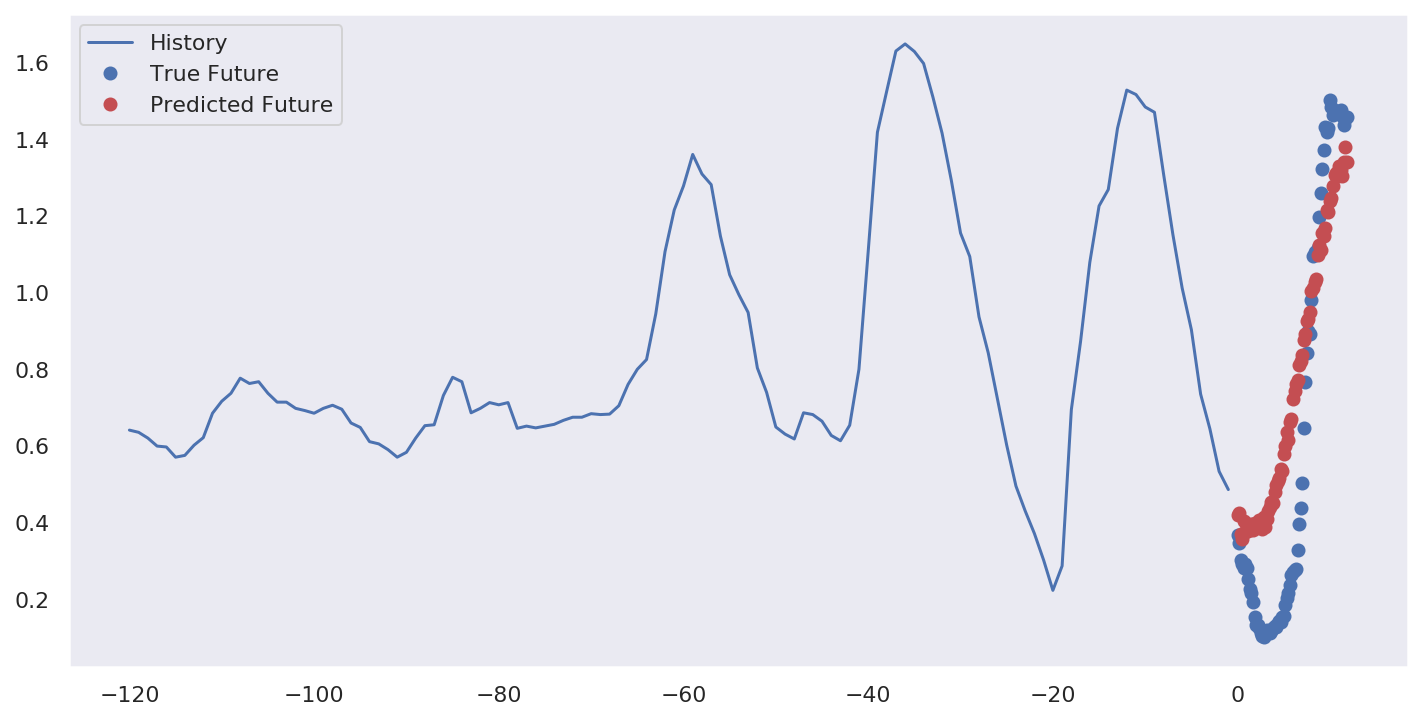

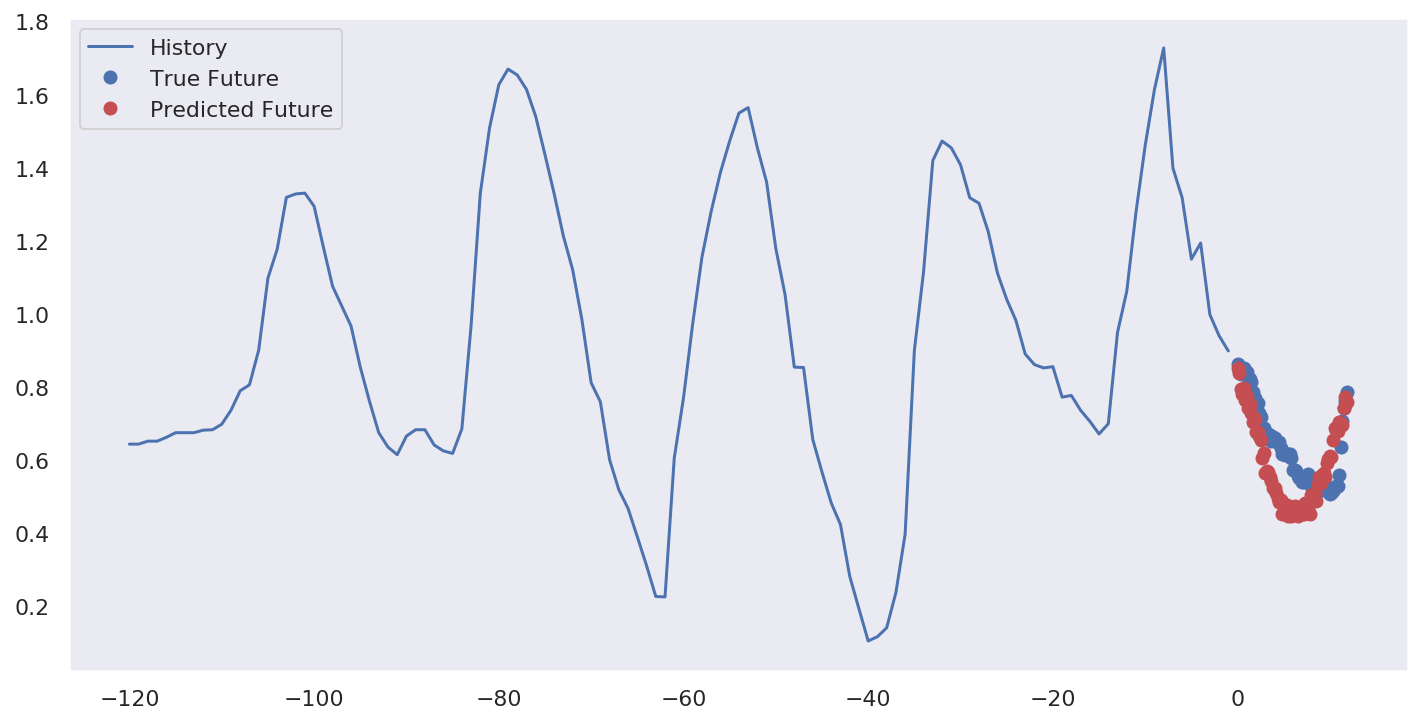

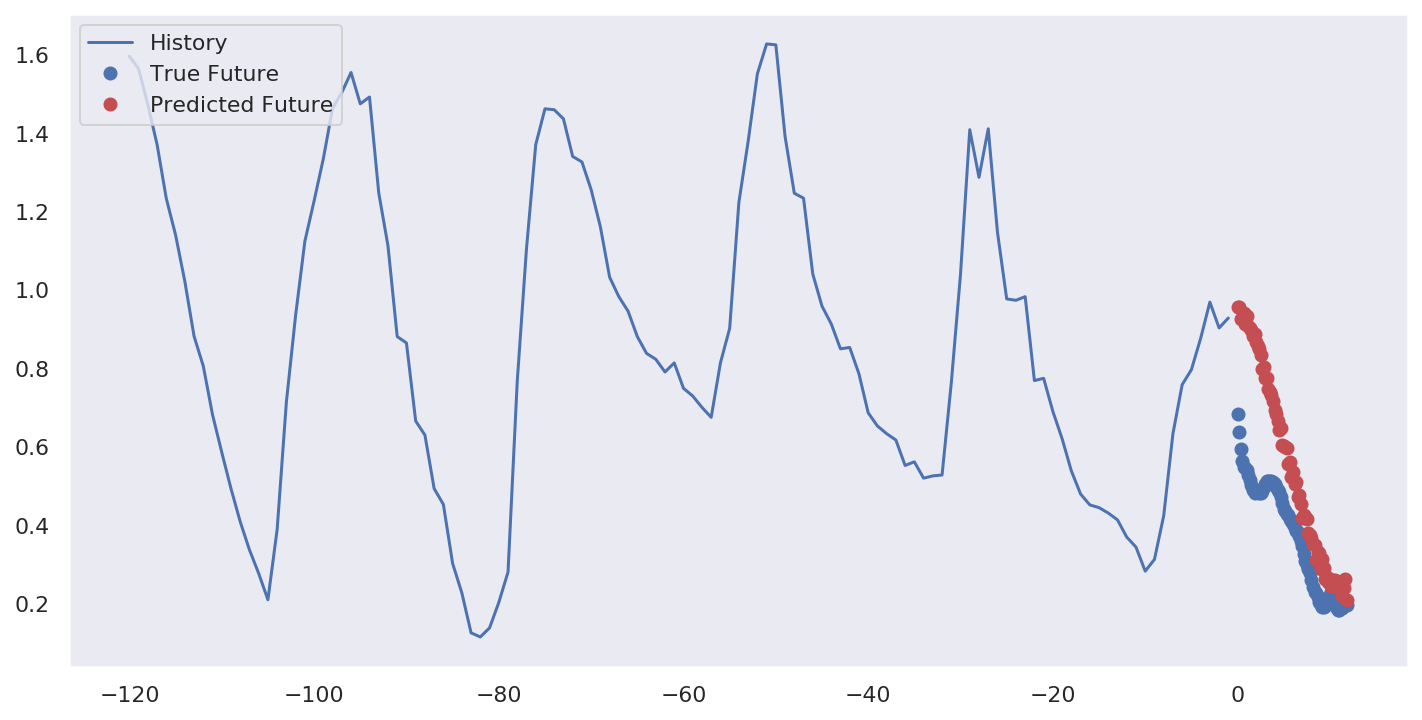

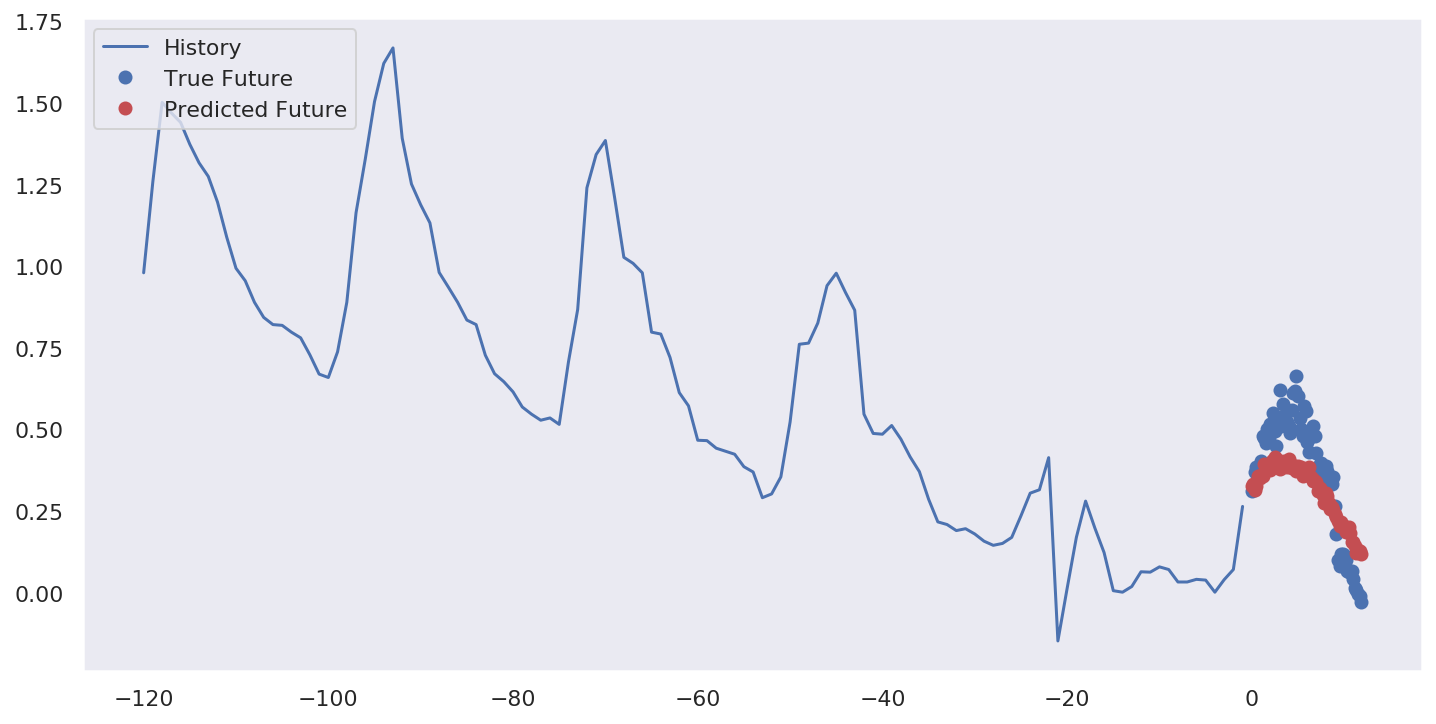

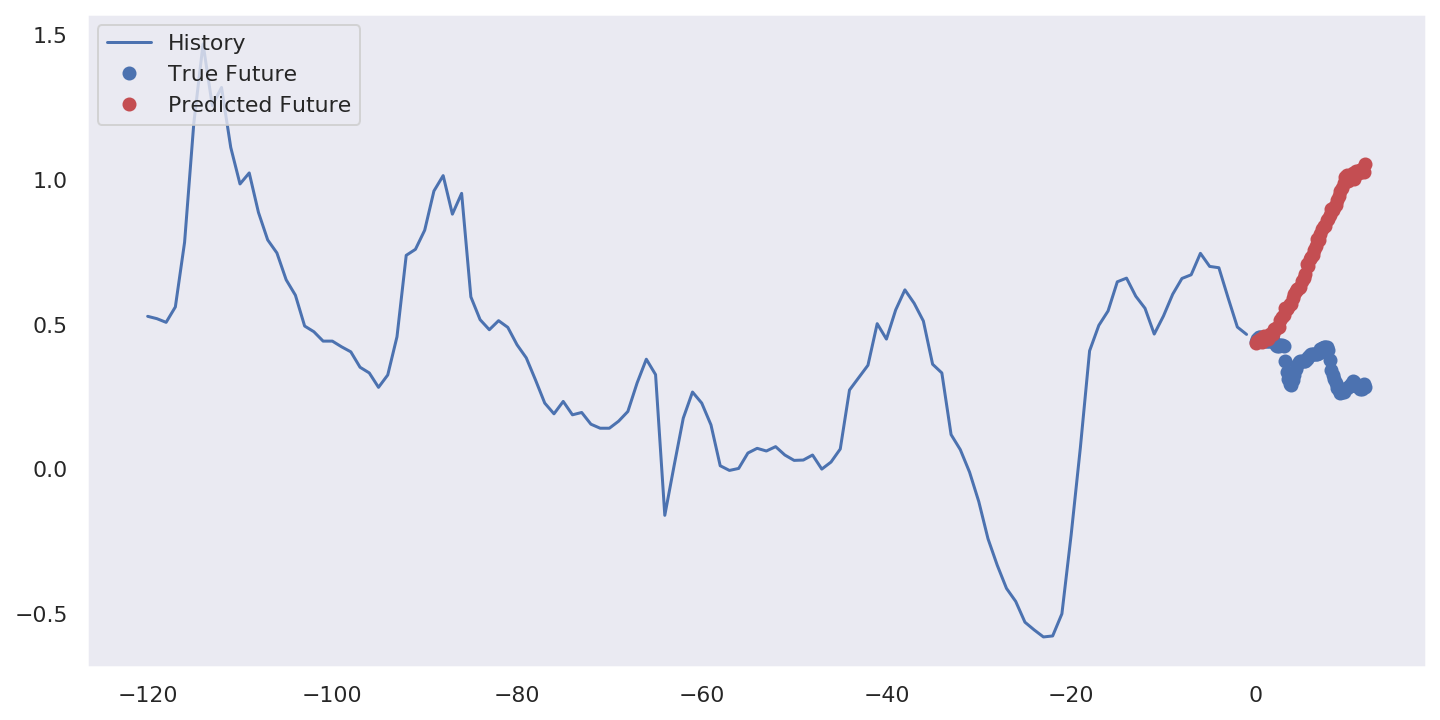

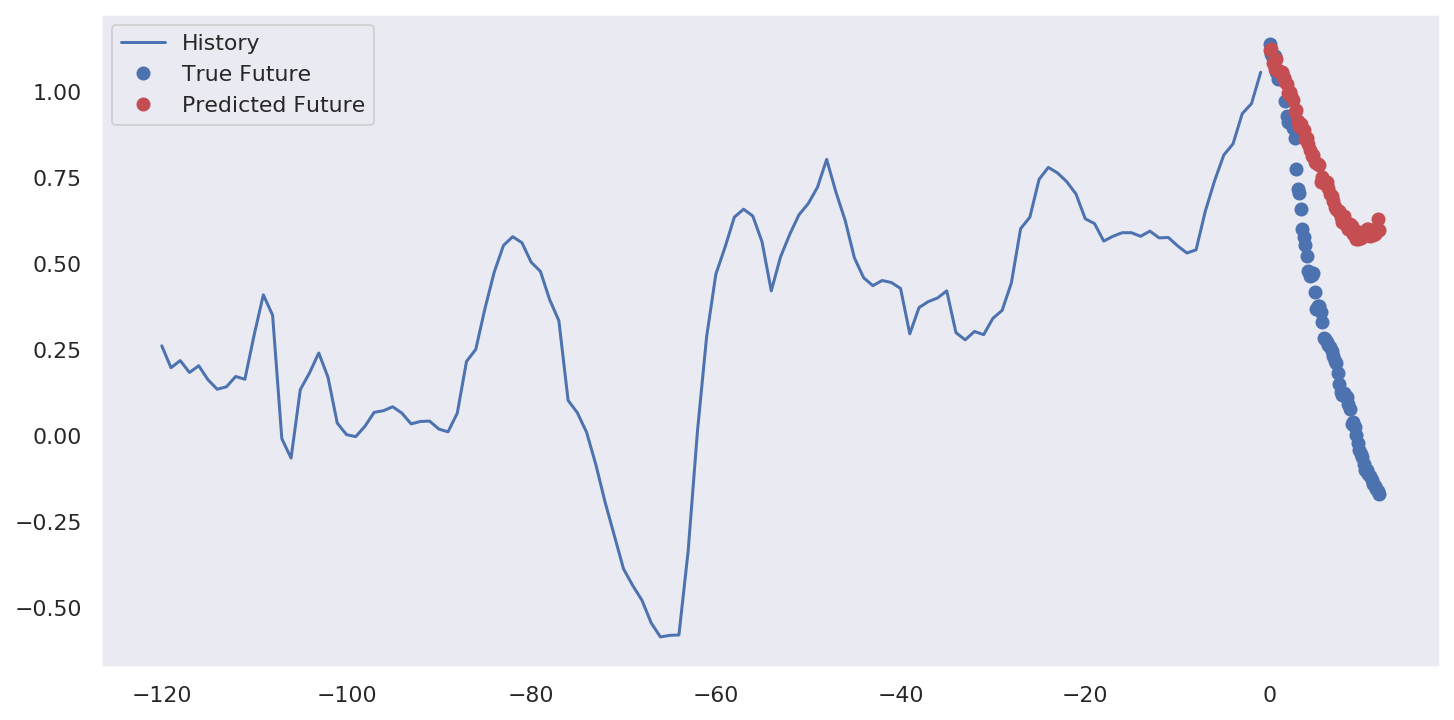

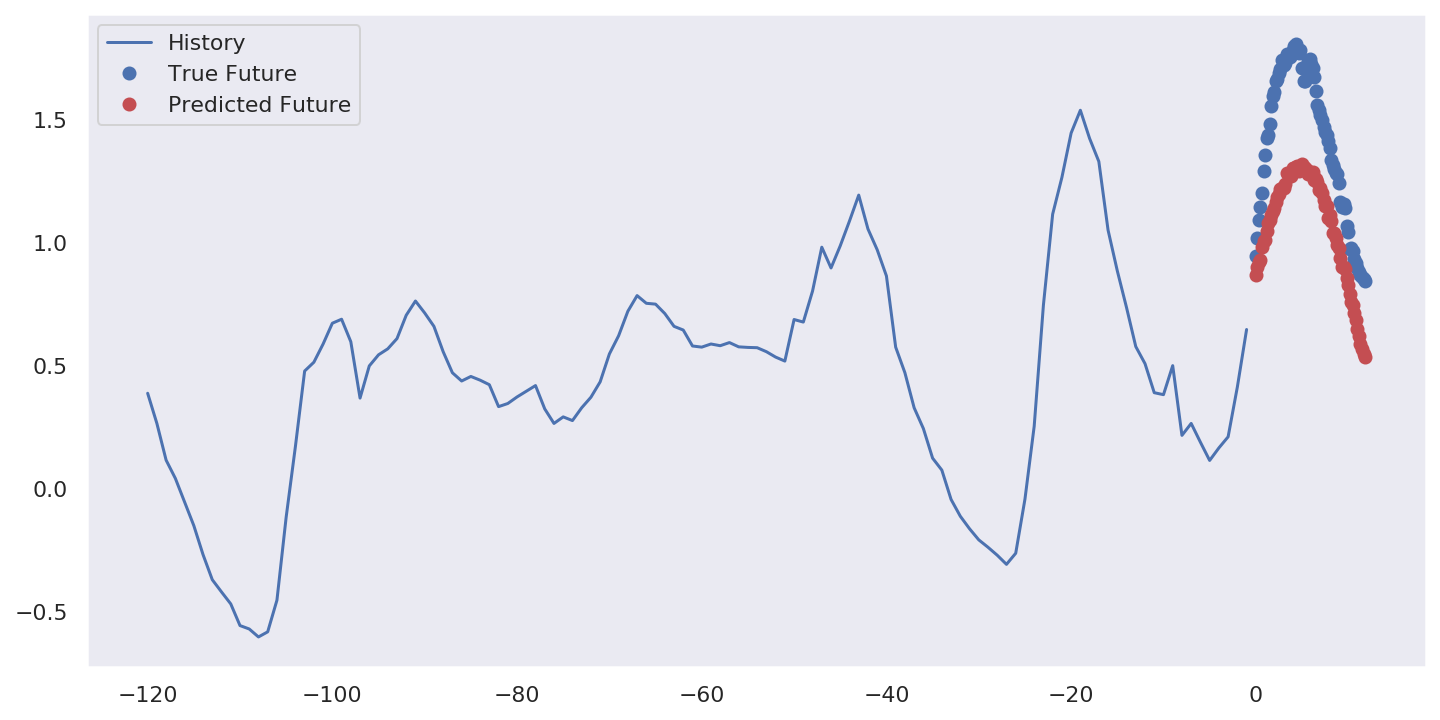

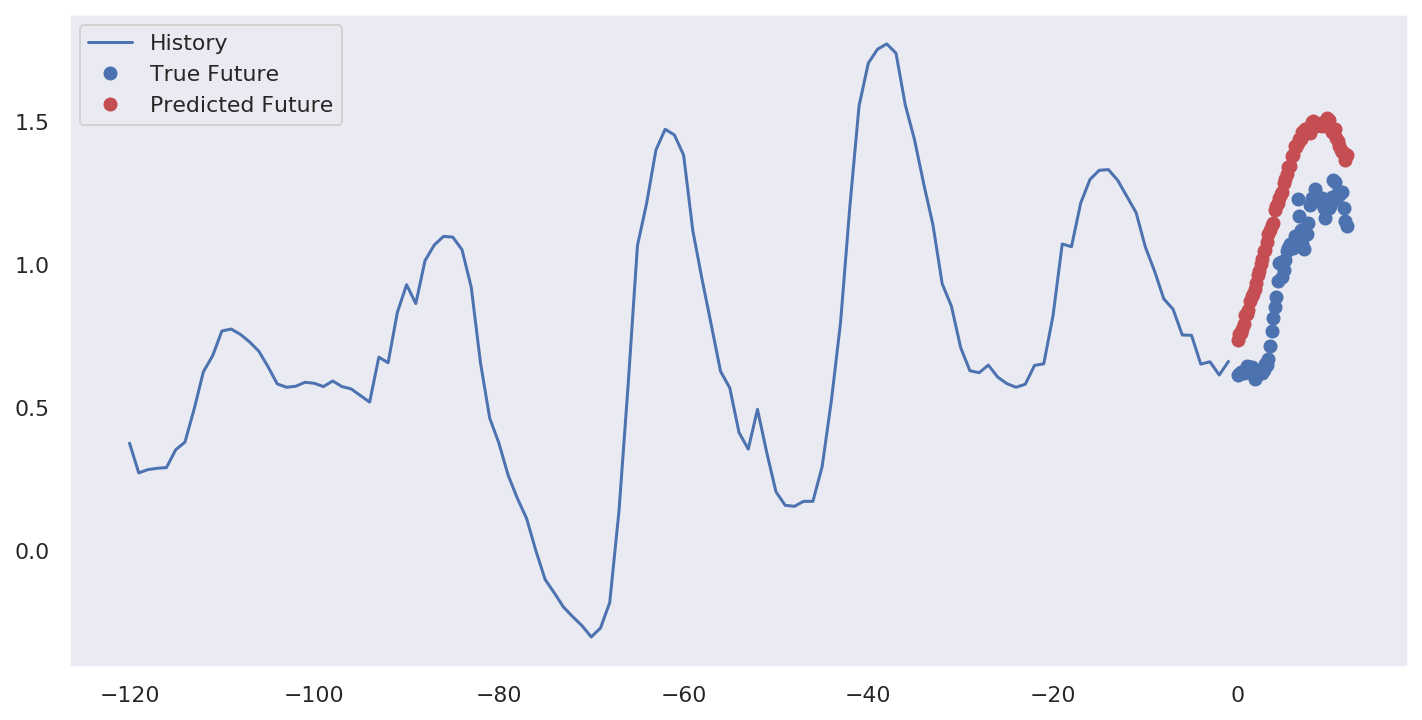

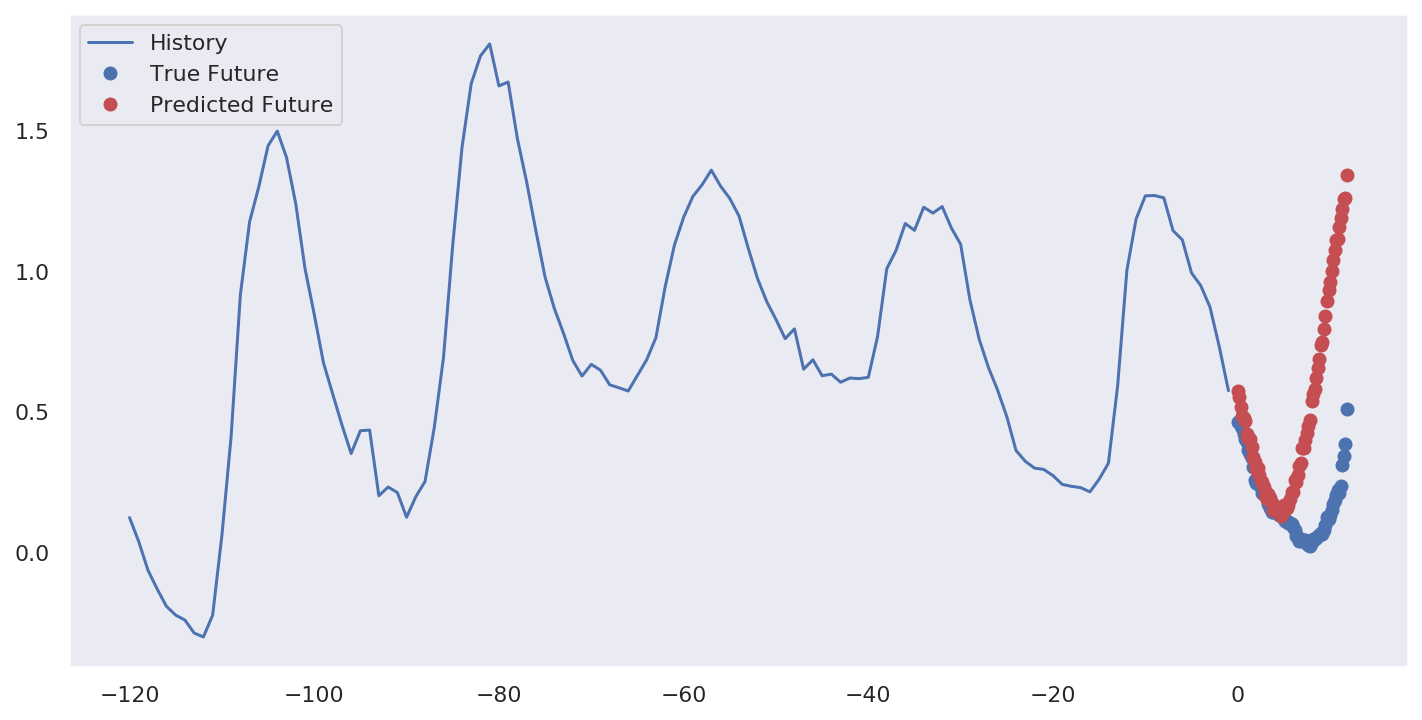

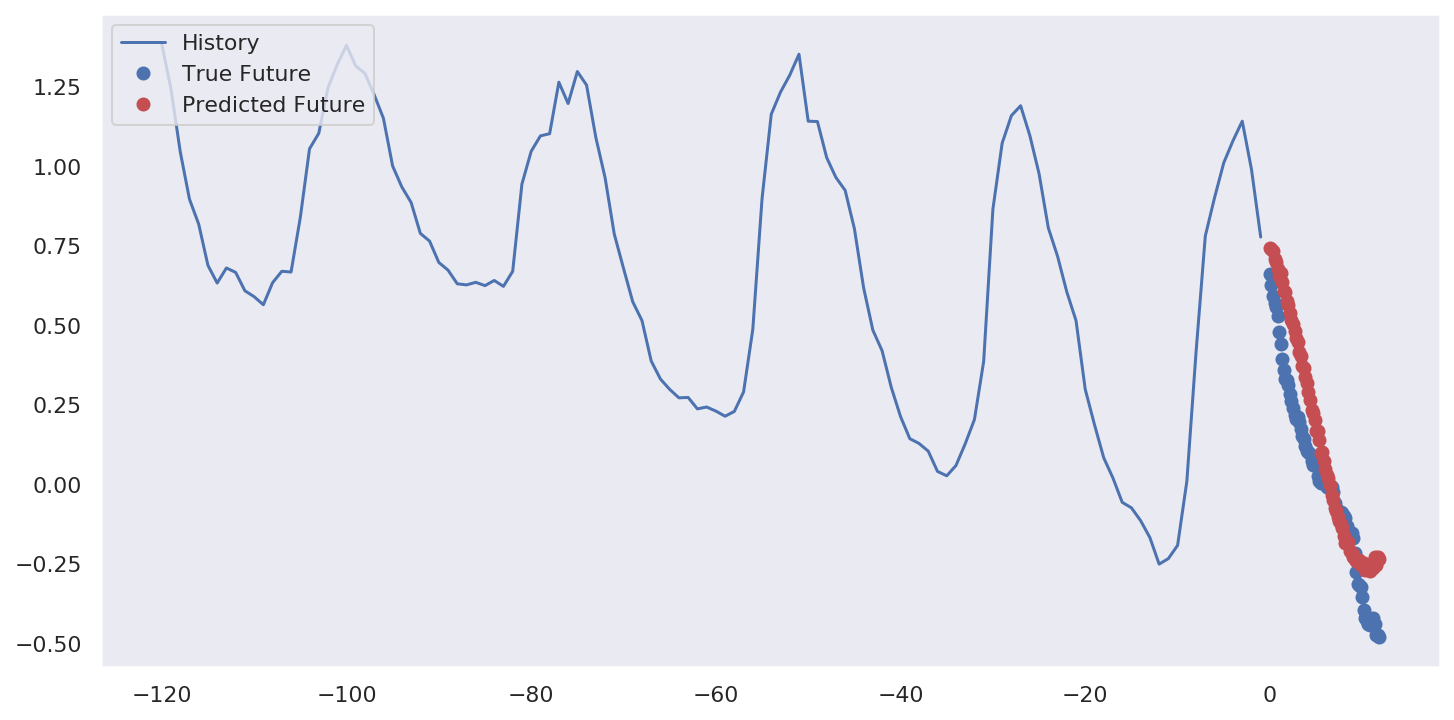

In [63]:
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])